 # Machine Learning
 
 Thomas Schuler - Nicolas Moine

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, preprocessing, model_selection, metrics, neural_network, ensemble, base, utils,svm, linear_model, neighbors
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools

# Introduction

La base PATER 2009 est une base de sondage réalisé en France en 2009. Ce sondage contient un très grand nombre de questions diverses et variés sur les comportements et préférences des français. Grâce à cette base, nous allons essayer de voir si il existe des profils de personnes préférant les Beatles au Rolling Stones. La variable f39_bis_1 = 0 si la personne préfére les Beatles et f39_bis_1 = 1 si elle préfère les Rolling Stones.

# Chargement de la base

In [2]:
df = pd.read_csv('pater_2009.csv')

# Nettoyage des données

In [3]:
#on fixe la valeur cible f39_bis_1
target = 'f39_bis_1'

In [4]:
#Répartition de la valeur cible
pd.crosstab(df[target],'Nombre')

col_0,Nombre
f39_bis_1,
-1.0,310
0.0,2135
1.0,1338


    On remarque donc ici, que 2135 personnes préfèrent les Beatles, 1338 préfèrent les Rolling Stones et 310 n'ont pas de préférence. On va ensuite enlever les personnes n'ayant pas répondu. Nous allons ensuite supprimer toutes les variables contenant plus de la moitié de valeurs manquantes. Nous allons ensuite supprimer les individus n'ayant répondu à la moitié des questions restantes après retrait des questions précédemment. Nous remplissons enuite les valeurs manquante grâce à l'algorithme pad, remplissant les valeurs manquantes grâce à des valeurs déjà existante. Nous sommes dans une base de donnée où toutes les variables sont catégorielles, c'est la meilleure façon de remplir ces données manquantes. Cependant, nous crééons quand même un biais sur notre classification.

In [5]:
df = df[df[target] != -1]

In [6]:
dfna = df.isna().describe().T
dfna = dfna[(dfna['top'] == False)]
df = df[list(dfna.index)]

In [7]:
df = df.replace(-1,np.NaN)
dfna = df.T.isna().describe().T
dfna = dfna[(dfna['top']==False)]
df = df.loc[dfna.index,:]

In [8]:
df.interpolate('pad',inplace=True)
df.drop(0, inplace=True)

Après avoir réglé les problèmes de valeurs manquantes, nous allons garder les variables avec la plus grande corrélation avec la variable cible, afin de garder en un minimum de variable le maximum d'information. La corrélation de Pearson n'étant pas une mesure cohérente pour mesurer la corrélation entre variable catégorielle, nous choisissons de mesurer la corrélation en calculant le V de Cramer. Nous choisissons un seuil de corrélation supérieur à 0.35 pour séléctionner nos variables. Nous retirons la variable de la csp, étant une variable catégorielle non ordonnée. 

In [13]:
df_corr = pd.DataFrame(columns=df.columns, index=df.columns)

for i in itertools.permutations(list(df.columns),2):
    table = pd.crosstab(df[i[0]],df[i[1]])
    #chi2 = stats.chi2_contingency(table)[0]
    #n = table.sum().sum()
    #dof = min(table.shape)-1
    #v = np.sqrt(chi2/(n*dof))
    #df_corr.loc[i[0],i[1]] = v
    #df_corr.loc[i[1],i[0]] = v
            

KeyboardInterrupt: 

In [11]:
names = list(df_corr[(corr[target]>0.35)|(df_corr[target]<-0.35)][target].index)
names.remove(target)
names.remove('year')
names.remove('wave')
names

NameError: name 'corr' is not defined

Nous regardons ensuite les problèmes de corrélation entre les variables. La plupart des algorithme de classification n'appréciant guère ces biais. Nous allons supprimé à la main les variables étant corrélé à plus de 0.80 entre elles.

In [ ]:
corr_var = df_corr[(df_corr > 0.8) & (df_corr < 1)].loc[names,names]
print(corr_var)

# Analyse

In [ ]:
for col in names:
    if col != target:
        cross = pd.crosstab(df[col], df[target])
        print(cross, "\n")


On remarque avec les tableaux croisés ci-dessus que très peu de variables sont discriminantes. On peut remarquer que les variables f39_bis_2, choix entre Tintin et le capitaine Haddock, f39_bis_3, choix entre Astérix et Obélix, montrent une petite séparation. 

# Arbre de Décision

In [ ]:
X = df[names]
y = df[target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.20, random_state=50)

In [ ]:
pd.crosstab(y_train,'Nombre')

Pour cette problématique, nous allons réaliser une classification via un arbre de décision. En effet, l'arbre de décision est une méthode assez simple, permettant facilement de trouver les variables discriminantes afin de définir le profil des individus. Afin de ne pas avoir un arbre trop complexe avec du sur-apprentissage, nous déterminons un nombre de noeuds par branche maximum de 10 avec une profondeur totale de 4. Nous fixons une diminutions des impurtés de 0.001, pour gardé un maximum de noeuds, tout en éliminant certains qui ne traite que trop peu d'information

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_features='auto', max_leaf_nodes=10,max_depth=4,random_state=42, min_impurity_decrease =0.001)
clf.fit(X,y)

In [ ]:
pred = clf.predict(X_test)

print("score AUC = " ,metrics.roc_auc_score(y_test,pred))
mat = metrics.confusion_matrix(y_test,pred)
T0 = mat[0][0]/(mat[0][0]+mat[0][1])
T1 = mat[1][1]/(mat[1][0]+mat[1][1])
print( " T0 = ",T0," & T1 = ",T1)



In [ ]:
cf_matrix = confusion_matrix(y_test,pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Pour mesurer la précision du modèle , nous utilisons 2 métriques différentes. La 1ère est l'aire en dessous de la courbe ROC. Elle est comprise entre 0.50 pour un modèle non-informatif et 100% pour un modèle parfait. Nous trouver ici un score AUC(Area Under the Courb) de 68%. Le modèle est assez performant sans être excellent. La 2ème est la sensitivité et la spécificité. La spécificité mesure le taux de bonne prédiction de la variable = 0 alors que la sensitivité regarde le teux de bonne prédiction quand la cible = 1. Ici les 2 sont aux alentours de 68%, ce qui signifie qu'on prédis de manière égale les 2 modalités. 

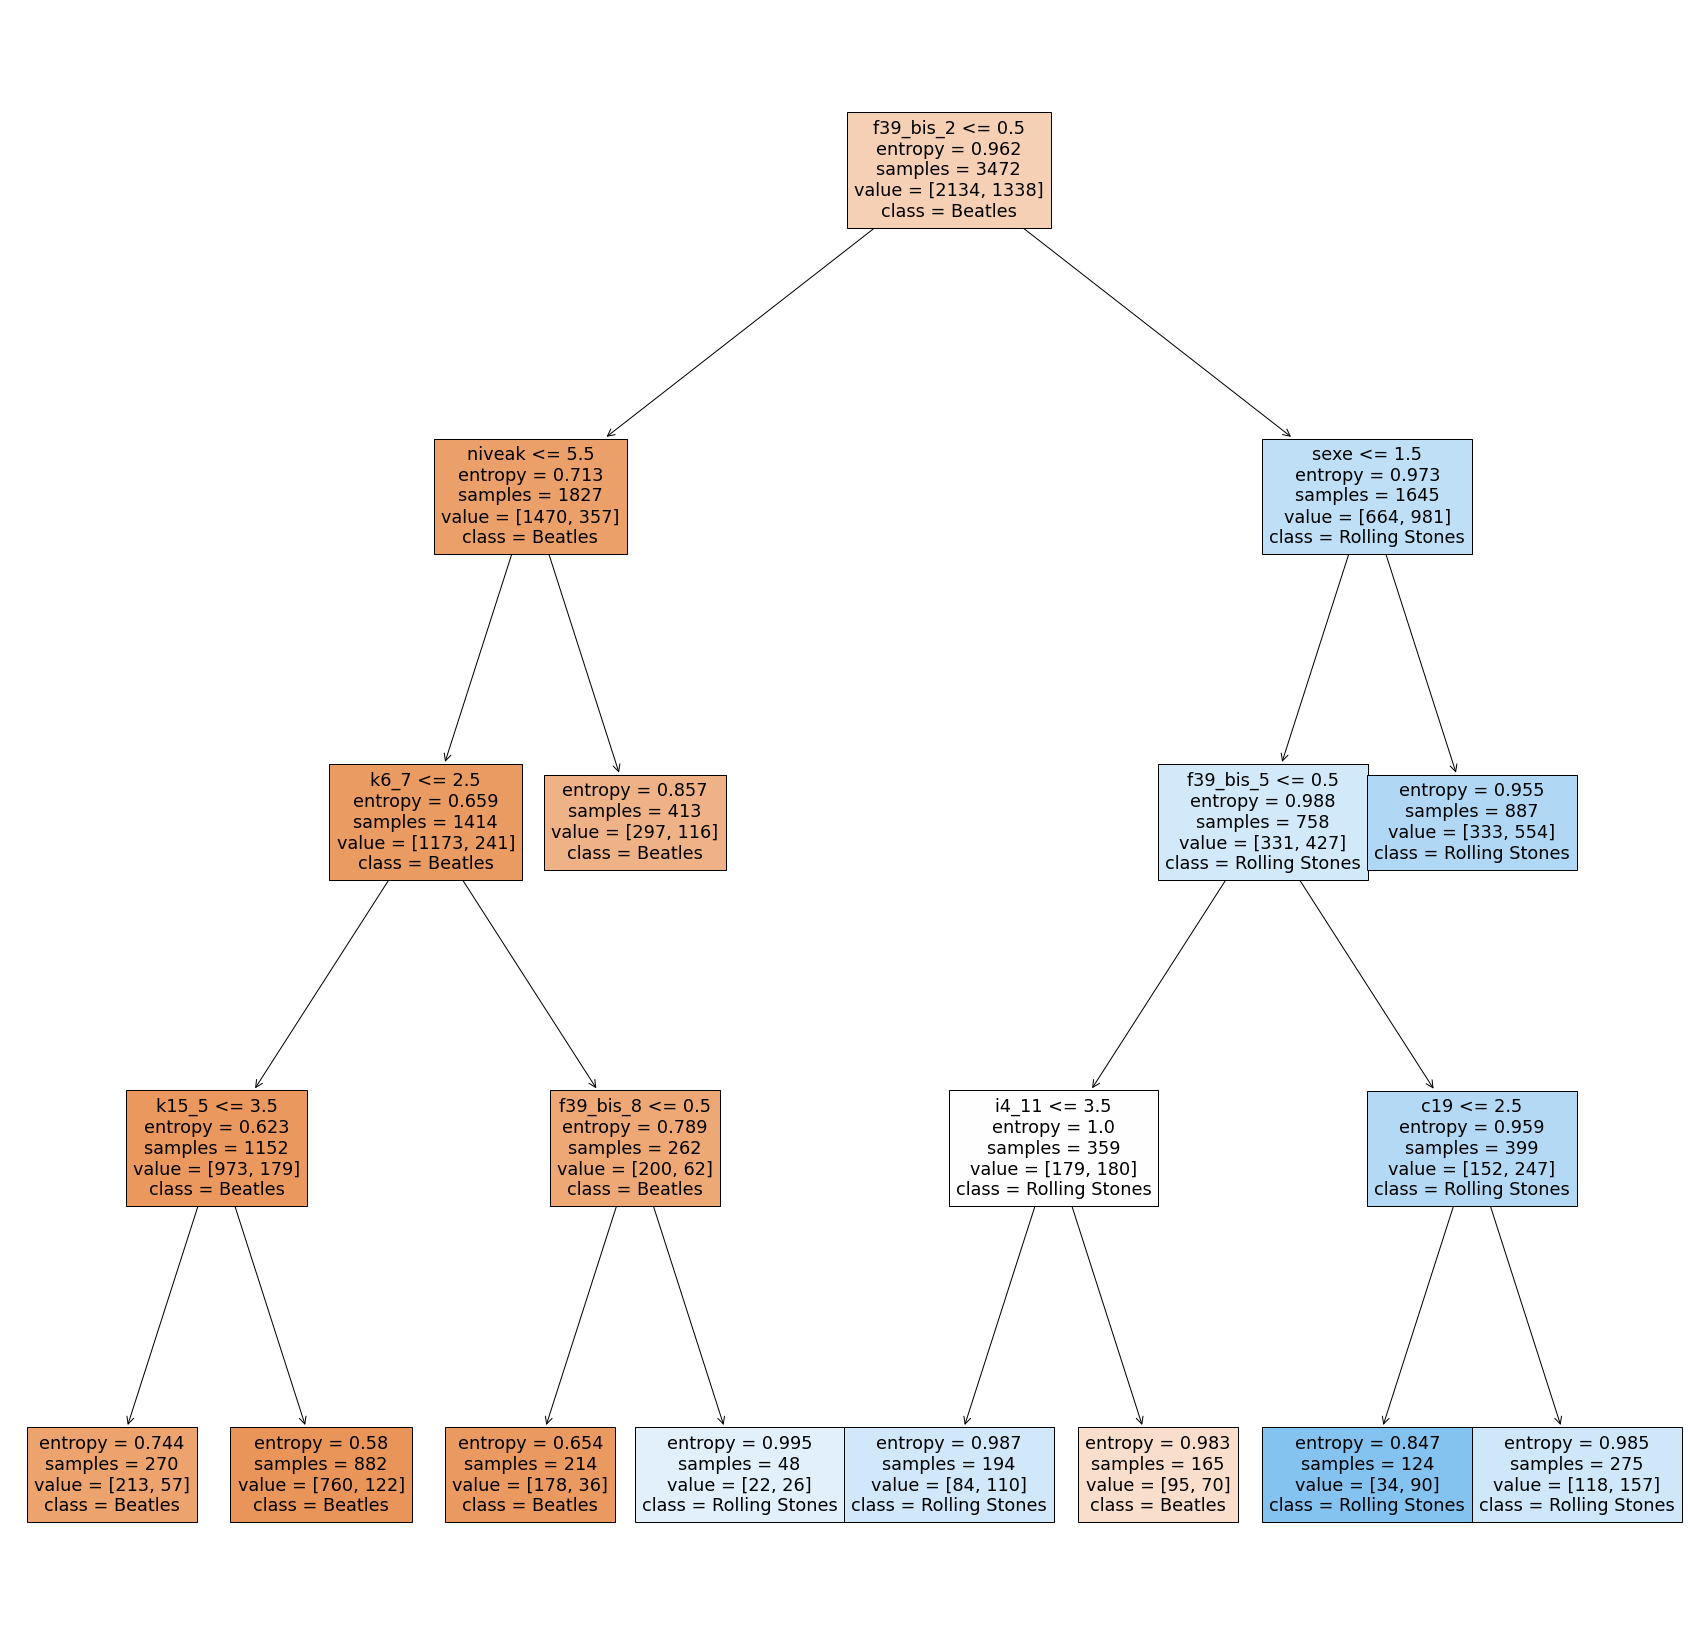

In [157]:
_, ax = plt.subplots(figsize=(30,30)) # Resize figure
tree.plot_tree(clf, feature_names=names, class_names=["Beatles","Rolling Stones"], ax=ax,filled=True)
plt.show()

On obtient donc l'arbre de décision suivant. On peuit remarquer que la variable f39_bis_2 arrive très bien à séparer les 2 classes. Ainsi en majorité, quelqu'un préférant Tintin au Capitaine Haddock va préférer les Beatles au Rolling Stones, en effet on peut voir ici des personnes plutôt rationnelle, préférant soit les héros lumineux (Tintin et les Beatles étant considérés comme des gentilhommes) soit les héros plus "bad boys". 
 Sur la branche de gauche, la variable f39_bis_2 suffit quasiment à déterminer la préférence. Seule la variable f39_bis arrive à identifier une ramification. Ceux préférant Laurel à Hardy préfèrent les Beatles, ce qui revient un peu à l'analyse précédente.
 
Sur la branche de gauche, cela revient au même que à droite. Seule la variable i4_11,n représentant si la personne est plutôt avare ou pas. On remarque les gens considérés comme vraiment avare vont préférer les Beatles alors que les autres vont préféré les Rolling Stones

Avant de comparer ce même modèle aux modèles suivant, il nous parait adapté d'avoir un objectif bien cibler : ici on cherche à partir d'un critère précis, la préférence entre Beatles et Rolling Stones, à comprendre la sous population qui se dessine et qui affiche ses préférences la.
On apprécie donc particulièrement l'approche exclusive de l'arbre de décision, qui en plus de faciliter l'intérprétation, répond très facilement à la question : quel environment socio économique justifie une préférence des beatles aux Rolling stones.

Pour autant on sait que mathématiquement il ne s'agit pas forcément du modèle le plus puissant et le plus efficace. 
En effet il perd souvent d'efficacité dès qu'il y a du bruit sur la base d'entraînement et il a pour défaut de souvent devenir trop spécifique.


In [164]:
svc = svm.SVC()
svc.fit(X_train, y_train)

pred = svc.predict(X_test)

print("score AUC = " ,metrics.roc_auc_score(y_test,pred))
mat = metrics.confusion_matrix(y_test,pred)
T0 = mat[0][0]/(mat[0][0]+mat[0][1])
T1 = mat[1][1]/(mat[1][0]+mat[1][1])
print( " T0 = ",T0," & T1 = ",T1)


score AUC =  0.5
 T0 =  1.0  & T1 =  0.0


Le modèle SVC, ne faisant pas mieux qu'un tirage aléatoire ne sera pas étudié plus en détail.

In [168]:
sgd = linear_model.SGDClassifier()
sgd.fit(X_train, y_train)

pred = sgd.predict(X_test)

print("score AUC = " ,metrics.roc_auc_score(y_test,pred))
mat = metrics.confusion_matrix(y_test,pred)
T0 = mat[0][0]/(mat[0][0]+mat[0][1])
T1 = mat[1][1]/(mat[1][0]+mat[1][1])
print( " T0 = ",T0," & T1 = ",T1)

score AUC =  0.5011600928074246
 T0 =  0.002320185614849188  & T1 =  1.0


Le modèle SGD, ne faisant pas mieux qu'un tirage aléatoire ne sera pas étudié plus en détail.

In [182]:
logit = linear_model.LogisticRegression(max_iter = 1200, multi_class = 'multinomial', penalty='elasticnet', solver='saga', l1_ratio=0.5)
logit.fit(X_train, y_train)

pred = logit.predict(X_test)

print("score AUC = " ,metrics.roc_auc_score(y_test,pred))
mat = metrics.confusion_matrix(y_test,pred)
T0 = mat[0][0]/(mat[0][0]+mat[0][1])
T1 = mat[1][1]/(mat[1][0]+mat[1][1])
print( " T0 = ",T0," & T1 = ",T1)

score AUC =  0.6491422344090557
 T0 =  0.7679814385150812  & T1 =  0.5303030303030303


La régression logistique a d'intéressant qu'elle traite de façon exclusive en fonction des paramètres du modèles si une population appartient à une population A (Beatles) ou B (rolling stones), en ayant fixé à 0.5, dès que la proba de l'individu dépasse 0.5 alors on affirme qu'il fait partie de la population B.
Pour autant ce modèle à deux soucis, il n'est pas exclusif sur les paramètres, ce qui est ce qui nous intéresse dans notre projet, et puis on note particulièrement une faiblesse sur T1. C'est à dire que la probabilité n'est pas homogène selon le groupe de population. Il est fort à détecter une catégorie mais pas l'autre.
Cela résulte de la maximisation qu'effectue le modèle. En effet il vise à minimiser le beta1 et beta2 qui représentent l'erreur de mesure effectué par le modèle pour identifier la sous population 1 et 2. Si il devient possible de minimiser plus l'un que l'autre, alors le modèle va accepter ce choix et accorder moins d'importance à l'un des deux. Il est compliqué de lui demander de rester homogène dans son travail de minimisation des deux beta.

In [213]:
knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='jaccard', weights='distance')
knn.fit(X_train, y_train)

pred = knn.predict(X_test)

print("score AUC = " ,metrics.roc_auc_score(y_test,pred))
mat = metrics.confusion_matrix(y_test,pred)
T0 = mat[0][0]/(mat[0][0]+mat[0][1])
T1 = mat[1][1]/(mat[1][0]+mat[1][1])
print( " T0 = ",T0," & T1 = ",T1)

score AUC =  0.6697119102861563
 T0 =  0.6310904872389791  & T1 =  0.7083333333333334


C:\Users\nicolas.moine\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Lorsqu'on effectue une KNN, on cherche à extirper du modèle un profil moyen de la personne appartenant à cette sous population.
Ainsi à faire un KNN sur notre projet, on va trouver les caractéristiques moyennes de la personne qui soutient un groupe de musique ou l'autre. Au demeurant lorsqu'on détient des variables catégorielles ordonnées la distinction d'une sous population peut se faire sur certaines modalités ce qui visuellement est compliqué à interpréter. En ce sens on reproche très vite à ce modèle de difficilement nous expliquer ce qui va faire la différence en